In [1]:
import glob
import fsl.utils.image.resample as resample
import fsl.data.atlases         as atlases
import fsl.data.image           as image
import fsl.transform.affine     as affine
#import fsl.transform.flirt      as flirt
import matplotlib.pyplot        as plt
import nibabel                  as nib
import numpy                    as np
import os

from fsl.transform.flirt        import fromFlirt, sformToFlirtMatrix
from fsl.utils.platform         import platform
from fsl.wrappers.bet           import bet
from fsl.wrappers.flirt         import flirt, applyxfm
from fsl.wrappers.misc          import fslreorient2std, fslorient
from nibabel.nifti1             import Nifti1Image



fsldir = os.path.join(platform.fsldir,'data','atlases')
fslPaths = sorted(glob.glob(os.path.join(fsldir, '*.xml')))

# Working with FSLpy

This notebook is for working with FSL by using the Python wrapper FSLpy. The documentation for the proper use of this wrapper can be found in the <a href="https://open.win.ox.ac.uk/pages/fsl/fslpy/index.html#"> Official Link </a> from FSLpy. The documentation for installation and usage of FSL utilities, is available through the FMRIB group webpage, specifically the <a href="https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL"> FSL installation</a> portal. 

To find the installation path of FSL in a Linux or macOS computer, just use FSLDIR variable on the terminal. With fslpy, we can do the same with fsl.utils.platform.fsldir, which is going to give us the exact same output as FSLDIR on zsh or bash.

In [2]:
!$FSLDIR

zsh:1: permission denied: /usr/local/fsl


In [3]:
platform.fsldir

'/usr/local/fsl'

To add all the atlases, just add them to the atlases object by looking into the FSL official directory. 

In [4]:
for file in fslPaths:
    atlases.addAtlas(file)
print("The Available Atlases on the $FSLDIR/data/atlases directory, are:")
atlases.listAtlases()

The Available Atlases on the $FSLDIR/data/atlases directory, are:


[AtlasDescription(cerebellum_mniflirt),
 AtlasDescription(cerebellum_mnifnirt),
 AtlasDescription(harvardoxford-cortical),
 AtlasDescription(harvardoxford-subcortical),
 AtlasDescription(smatt),
 AtlasDescription(jhu-labels),
 AtlasDescription(jhu-tracts),
 AtlasDescription(juelich),
 AtlasDescription(marsparietalparcellation),
 AtlasDescription(marstpjparcellation),
 AtlasDescription(mni),
 AtlasDescription(neubertventralfrontalparcellation),
 AtlasDescription(thalamus),
 AtlasDescription(striatum-connectivity-3sub),
 AtlasDescription(striatum-connectivity-7sub),
 AtlasDescription(striatum-structural),
 AtlasDescription(salletdorsalfrontalparcellation),
 AtlasDescription(stn),
 AtlasDescription(talairach),
 AtlasDescription(xtract),
 AtlasDescription(xtract_mac)]

## Loading the Atlases

Now, we can look into the different atlases, one first approach is to look into the already segmented volumes, which are stored in the /data/atlases directory. These atlases have an already segmented object, with different anatomical parts of the brain. In the case of MNI152, we can see the mean volumes of 9 different manually segmented (by experts, this is considered the "ground truth") parts of the brain. The "mean" volumes are taken from the analysis of 152 brains of developed adults. 

If we perform an image registration approach with a patient with the MNI brain, we will be able to always have the same location in all the patients. Also, as the MNI atlas is in the "Standard Space" (as we can check in the documentation of any different neurological imaging suite, it is a space that is centered in the center of mass of the MNI + the voxel distance is 1 mm from each other, i.e. it has physical interpretation...), it is easier to find where is each of the brain structures on the images.

Let's look at the segmented image, and the estructural image.

### Segmented Image:



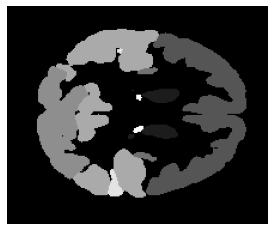

In [5]:
MNI = atlases.loadAtlas('mni', resolution=1.0, loadSummary=True).nibImage.get_fdata()
MNI.shape
plt.imshow(MNI[:,:,91], cmap='gray')
plt.axis('off')
plt.show()

### Structural Image

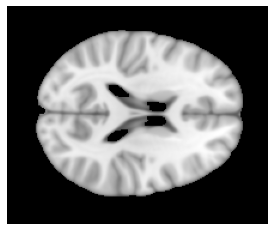

In [6]:
MNI_map = nib.load(os.path.join(platform.fsldir,'data','standard','MNI152_T1_1mm_brain.nii.gz')).get_fdata()
plt.imshow(MNI_map[:,:,91], cmap='gray')
plt.axis('off')
plt.show()

### Checking the Two images on the FSLeyes viewer

We can also check the difference by using fsleyes (run fsleyes in a terminal), from the main suite, and add the two of them, as they are aligned in the Standard Space. An image of the FSLeyes interface is displayed:

<p align="center">
<img src="fsleyes_with_atlas.png" alt="FSLeyes image with the Atlas and the segmentation of the Atlas displayed">
</p>

The fsleyes interface in the atlas panel, also gives us the part of the brain corresponding to the selected pixel on the grid. To add it, >View>Ortho View>Atlases/Atlas panel will add it to the interface, from there we can add any desired panel.

## Looking into Structural Images

The shape of the structural image is (160, 224, 256)


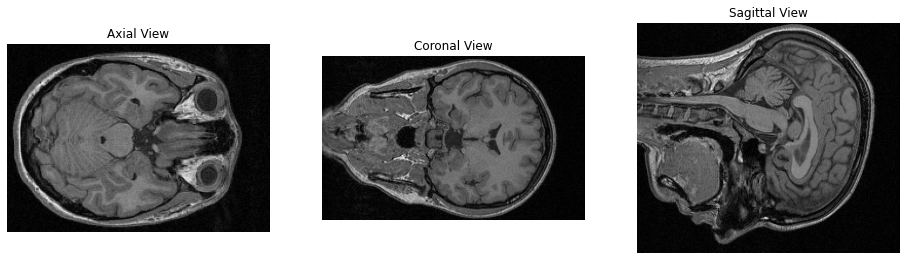

In [7]:
struct_image_path = '/Users/cesarasa/fsl_course_data/intro/bighead.nii.gz'
struct_image_path_brain = 'bighead_brain.nii.gz'

struct_image = nib.load(struct_image_path).get_fdata()

print(f"The shape of the structural image is {struct_image.shape}")

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(struct_image[:,:,256//2], cmap='gray')
plt.axis('off')
plt.title('Axial View')

plt.subplot(1,3,2)
plt.imshow(struct_image[:,224//2,:], cmap='gray')
plt.axis('off')
plt.title('Coronal View')

plt.subplot(1,3,3)
plt.imshow(struct_image[160//2,:,:], cmap='gray')
plt.axis('off')
plt.title('Sagittal View')

plt.show()

### BET wrapper

In [8]:
bet(struct_image_path, struct_image_path_brain, mask=True, robust=True, fracintensity=0.5)

{}

### Visualizing the Result of the Brain Extraction (Skull-Stripping)

Text(0.5, 1.0, 'Extracted Brain')

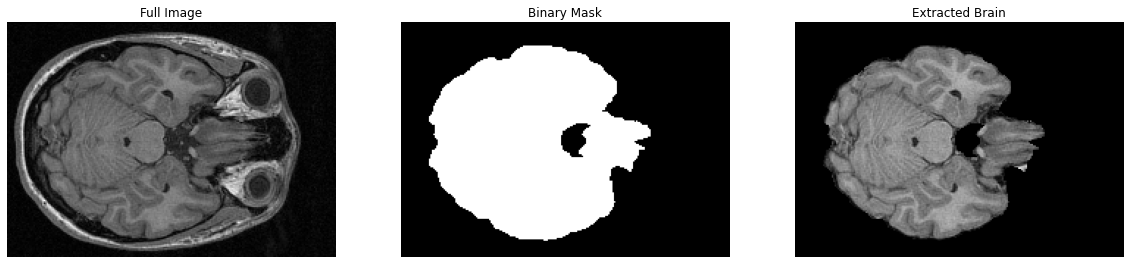

In [9]:
struct_image_path_brain_mask = 'bighead_brain_mask.nii.gz'
struct_image_brain = nib.load(struct_image_path_brain).get_fdata()
struct_image_brain_mask = nib.load(struct_image_path_brain_mask).get_fdata()

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(struct_image[:,:,256//2], cmap='gray')
plt.axis('off')
plt.title('Full Image')

plt.subplot(1,3,2)
plt.imshow(struct_image_brain_mask[:,:,256//2], cmap='gray')
plt.axis('off')
plt.title('Binary Mask')

plt.subplot(1,3,3)
plt.imshow(struct_image_brain[:,:,256//2], cmap='gray')
plt.axis('off')
plt.title('Extracted Brain')

### Further Preprocessing: Proper orientation of the Different Views:

In [10]:
# REORIENTATION TO CANONICAL OR STANDARD SPACE
struct_image_path_brain_corrected = 'bighead_brain_corrected.nii.gz'
fslreorient2std(nib.load(struct_image_path_brain), output=struct_image_path_brain_corrected)

{}

### FLIRT:

For some reason that I really like about the people from FSL, the names of the different apps from the suite are quite funny and intuitive, which makes them easy to remember. FLIRT stands for FSL LInear Registration Tool, which computes affine transformations easily. This is an extremely useful tool in our case. I will be using this to coregister the extracted brain image to the atlas brain image.

In [13]:
# Image with 2mm atlas:
ref = os.path.join(platform.fsldir,'data','standard','MNI152_T1_2mm_brain.nii.gz')
matrix_path = 'result_matrix.mat'
flirt(src=struct_image_path_brain_corrected,ref=ref, out=struct_image_path_brain_corrected+'_flirt_2mm', omat=matrix_path)

# Image with 1mm atlas (There is no need in Looking two times at Affine Matrices):
ref = os.path.join(platform.fsldir,'data','standard','MNI152_T1_1mm_brain.nii.gz')
flirt(src=struct_image_path_brain_corrected,ref=ref, out=struct_image_path_brain_corrected+'_flirt_1mm')

{}

### NOTE: 

We can use either the 1mm voxel size atlas, or the 2mm voxel size atlas, to perform our tasks. The 2mm will get us smaller images, in exchange for less resolution. Take that into consideration when preprocessing images!

<h4>The 2mm Image: </h4>

<p align="center">
<img src="2mm_im.png" alt="FSLeyes image with the Atlas and the segmentation of the Atlas displayed">
</p>

The image is 91x109x91.

<h4>The 1mm Image: </h4>

<p align="center">
<img src="1mm_im.png" alt="FSLeyes image with the Atlas and the segmentation of the Atlas displayed">
</p>

The image is 182x218x182.